# Evaluate noise sensitivity of all methods

An investigation of noise robustness for global and local analysis strategies. After running sections "Preparation" and "File selection and input parameters", the section of interest can be run independently.

## Preparation
Import of required modules/packages and function definitions.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

from min_analysis_tools import correlation_tools
from min_analysis_tools.get_auto_halfspan import get_auto_halfspan
from min_analysis_tools.local_velocity_analysis import local_velocity_analysis
from min_analysis_tools import peak_profile
from IPython.display import clear_output

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

plt.rc("font", size=10)  # controls default text size
plt.rcParams.update({"font.family": "arial"})

In [2]:
# save set to True -> selected images saved to save_output
save = False
save_dpi = 150
cm = 1 / 2.54  # centimeters in inches (for matplotlib figure size)

In [3]:
def spatial_autocorrelation(Min_st, frames_to_analyse):
    nt, ny, nx = np.shape(Min_st)
    title = f"size: {nx} pixels x {ny} pixels"

    # calculate spatial autocorrelation maps for all analysed frames
    (crmx_storage) = correlation_tools.get_spatial_correlation_matrixes(
        Min_st, frames_to_analyse, demo=False
    )
    # calculate radially averaged profile traces and analyze them with respect to first min and max
    (
        min_pos,
        min_val,
        max_pos,
        max_val,
    ) = correlation_tools.analyze_radial_profiles(crmx_storage, demo=False)

    wavelength = np.mean(max_pos)
    wavelength_std = np.std(max_pos)
    print(
        f"Position of first valley: ({np.mean(min_pos):.02f} ± {np.std(min_pos):.02f}) pixels"
    )
    print(f"Wavelength: ({wavelength:.02f} ± {wavelength_std:.02f}) pixels")
    print("")

    return wavelength, wavelength_std

In [4]:
def temporal_autocorrelation(MinDE_st, kymoband, reps_per_kymostack):

    nt, ny, nx = np.shape(MinDE_st)

    slices2analyze_x = ny * np.linspace(
        0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
    )
    slices2analyze_x = slices2analyze_x.astype(int)

    slices2analyze_y = nx * np.linspace(
        0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
    )
    slices2analyze_y = slices2analyze_y.astype(int)

    nt, ny, nx = np.shape(MinDE_st)

    # reslice frames
    MinDE_shift_tx = np.moveaxis(MinDE_st, 0, -1)  # creates t-x resliced frames
    MinDE_shift_yt = np.moveaxis(MinDE_st, -1, 0)  # creates y-t resliced frames

    # next transpose y-t slices to have t axis in 1st dimension
    MinDE_shift_ty = np.empty((nx, ny, nt))
    for frame in range(nx):
        MinDE_shift_ty[frame, :, :] = np.transpose(MinDE_shift_yt[frame, :, :])

    (
        crmx_storage_x,
        slices2analyze,
    ) = correlation_tools.get_temporal_correlation_matrixes(
        MinDE_shift_tx,
        "x",
        kymoband,
        reps_per_kymostack,
        demo=False,
    )
    (
        first_min_pos_x,
        first_min_val_x,
        first_max_pos_x,
        first_max_val_x,
    ) = correlation_tools.analyze_temporal_profiles(
        "x", crmx_storage_x, slices2analyze_x, demo=False
    )

    (
        crmx_storage_y,
        slices2analyze_y,
    ) = correlation_tools.get_temporal_correlation_matrixes(
        MinDE_shift_ty,
        "y",
        kymoband,
        reps_per_kymostack,
        demo=False,
    )
    (
        first_min_pos_y,
        first_min_val_y,
        first_max_pos_y,
        first_max_val_y,
    ) = correlation_tools.analyze_temporal_profiles(
        "y", crmx_storage_y, slices2analyze_y, demo=False
    )

    all_minima = np.append(first_min_pos_x, first_min_pos_y)
    all_maxima = np.append(first_max_pos_x, first_max_pos_y)

    period = np.mean(all_maxima)
    period_std = np.std(all_maxima)
    print(
        f"Position of first valley: ({np.mean(all_minima):.02f} ± {np.std(all_minima):.02f}) frames"
    )
    print(f"Oscillation period: ({period:.02f} ± {period_std:.02f}) frames")
    print("")

    return period, period_std

In [5]:
def add_gaussian_noise(img, mean=0, std=1):
    gaussian_noise = np.random.normal(mean, std, img.shape)
    noise_img = img + gaussian_noise
    return noise_img

## File selection and input parameters

Select input path:

In [6]:
stack_path = Path().cwd() / "example_data" / "paper_example.tif"

Select noise ratios for Gaussian noise to add to the image. A ratio of 1 means, that the standard deviation of the added noise equals the standard deviation of the original image. The latter one is associated with the peaks and valleys of the wave pattern. The higher the ratio, the noisier the resulting image.

In [7]:
gauss_std_ratio = np.float64([0.02, 0.2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

General / display paramters:

In [8]:
frames_to_analyse = 6  # analyse first .. frames (global/spatial and local analysis)

Temporal autocorrelation analysis parameters:

In [9]:
reps_per_kymostack = 10  # pick ... kymographs around middle
kymoband = 0.8  # analyse middle ... part of image

Local analysis parameters:

In [10]:
halfspan = None  # set to "None" to use automatic halfspan (recommended!)
sampling_width = 0.25  # in pixel units
edge = 30  # outer edge (+/-) for velocity wheel and velocity histogram
bins_wheel = 50  # number of horizontal/vertical bins for histogram wheels
binwidth_sum = 0.25  # binwidth for velocity magnitude histogram (in pixel/frame)
kernel_size_general = 20  # kernel for first smoothing step (smaller)
kernel_size_flow = 35  # building smoothening kernel needed for flow analysis (larger)

## Display noisy images

Input file: paper_example, size: 512 pixels x 512 pixels x 20 frames


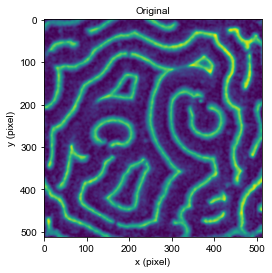

image noise level: 400.96 a.u.


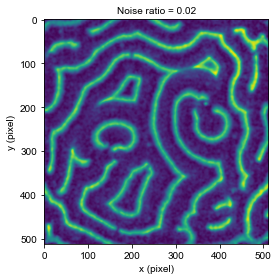

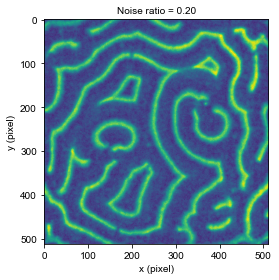

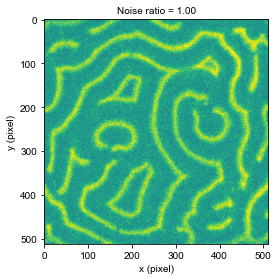

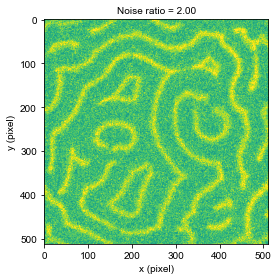

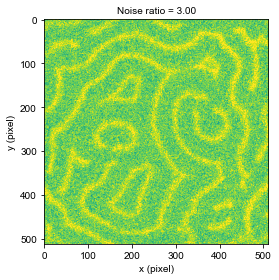

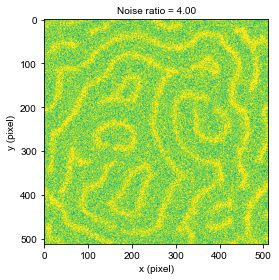

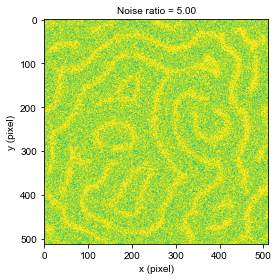

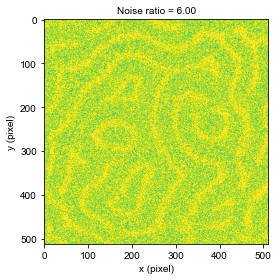

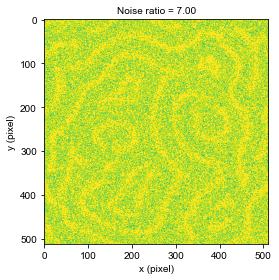

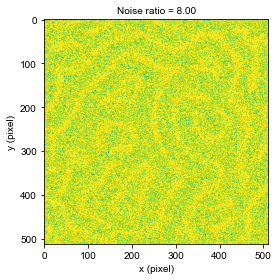

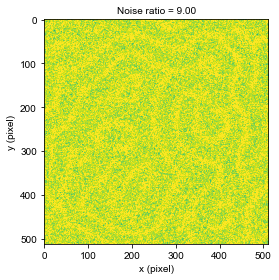

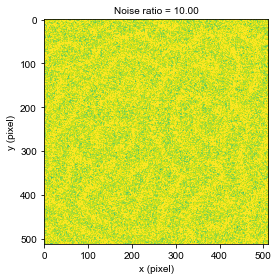

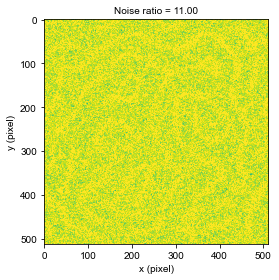

In [11]:
wavelengths_collect = []
wavelengths_std_collect = []

# First original image
Min_st = io.imread(stack_path)
stackname = stack_path.stem
nt, ny, nx = np.shape(Min_st)
print(f"Input file: {stackname}, size: {nx} pixels x {ny} pixels x {nt} frames")
vmax = np.max(Min_st[0, :, :])  # ensure same color scale for both images

fig, ax = plt.subplots(1, 1)
ax.imshow(Min_st[0, :, :], vmax=vmax)
ax.set_title("Original", fontsize=10)
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")

if save:
    fig.set_size_inches(3.6 * cm, 3.6 * cm)
    ax.set_xlabel("")
    ax.set_ylabel("")
    fig.tight_layout()
    fig.savefig(f"save_output/noisy_image_std_0.png", dpi=save_dpi, transparent=True)
plt.show()

image_std = np.std(Min_st[0, :, :])
print(f"image noise level: {image_std:.02f} a.u.")
gauss_std = image_std * gauss_std_ratio

# Next, create noisy images and analyse as well
for std in gauss_std:

    Min_st_noise = np.empty((nt, ny, nx))
    for frame in range(nt):
        img = Min_st[frame, :, :]
        noise_img = add_gaussian_noise(img, mean=0, std=std)
        Min_st_noise[frame, :, :] = noise_img

    fig, ax = plt.subplots(1, 1)
    ax.imshow(Min_st_noise[0, :, :], vmax=vmax)
    ax.set_title(f"Noise ratio = {std/image_std:.02f}", fontsize=10)
    ax.set_xlabel("x (pixel)")
    ax.set_ylabel("y (pixel)")
    fig.tight_layout()

    if save:
        fig.set_size_inches(3.6 * cm, 3.6 * cm)
        ax.set_xlabel("")
        ax.set_ylabel("")
        fig.tight_layout()
        fig.savefig(
            f"save_output/noisy_image_std_{std/image_std:.02f}.png",
            dpi=save_dpi,
            transparent=True,
        )

## Global spatial analysis

In [12]:
wavelengths_collect = []
wavelengths_std_collect = []

# First original image
Min_st = io.imread(stack_path)
stackname = stack_path.stem
nt, ny, nx = np.shape(Min_st)
print(f"Input file: {stackname}, size: {nx} pixels x {ny} pixels x {nt} frames")
vmax = np.max(Min_st[0, :, :])  # ensure same color scale for both images

print("Analysing original image:")
ref_wavelength, ref_wavelength_std = spatial_autocorrelation(Min_st, frames_to_analyse)

# Next, create noisy images and analyse as well
for std in gauss_std:

    Min_st_noise = np.empty((nt, ny, nx))
    for frame in range(nt):
        img = Min_st[frame, :, :]
        noise_img = add_gaussian_noise(img, mean=0, std=std)
        Min_st_noise[frame, :, :] = noise_img

    print(f"Analysing noisy image with standard deviation {std}:")
    wavelength, wavelength_std = spatial_autocorrelation(
        Min_st_noise, frames_to_analyse
    )
    wavelengths_collect.append(wavelength)
    wavelengths_std_collect.append(wavelength_std)

    clear_output(wait=False)

### Results:

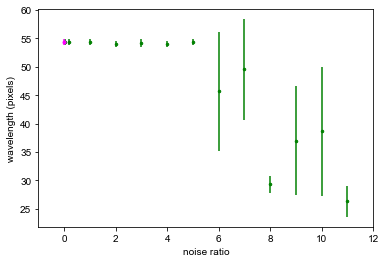

In [13]:
fig, ax = plt.subplots()

ax.set_xlabel("noise ratio")
ax.set_ylabel("wavelength (pixels)")

max_std = max(gauss_std) / image_std
ax.set_xlim((-1, max_std + 1))

for n, std in enumerate(gauss_std):
    wavelength = wavelengths_collect[n]
    wavelength_std = wavelengths_std_collect[n]
    if wavelength > 0:
        ax.errorbar(
            std / image_std,
            wavelength,
            yerr=wavelength_std,
            marker=".",
            markersize=5,
            color="green",
        )
    else:
        ax.axvline(x=std / image_std, linestyle="dotted", color="blue", linewidth=1)

ax.errorbar(
    0,
    ref_wavelength,
    yerr=ref_wavelength_std,
    marker=".",
    markersize=6,
    color="magenta",
)

if save:
    fig.set_size_inches(9 * cm, 5 * cm)
    fig.tight_layout()
    fig.savefig(
        f"save_output/global_spatial_noise_results.png", dpi=save_dpi, transparent=True
    )
plt.show()

## Global temporal analysis

In [14]:
periods_collect = []
periods_std_collect = []

# First original image
Min_st = io.imread(stack_path)
stackname = stack_path.stem
nt, ny, nx = np.shape(Min_st)
print(f"Input file: {stackname}, size: {nx} pixels x {ny} pixels x {nt} frames")
vmax = np.max(Min_st[0, :, :])  # ensure same color scale for both images

print("Analysing original image:")
ref_period, ref_period_std = temporal_autocorrelation(
    Min_st, kymoband, reps_per_kymostack
)

# Next, create noisy images and analyse as well
for std in gauss_std:

    Min_st_noise = np.empty((nt, ny, nx))
    for frame in range(nt):
        img = Min_st[frame, :, :]
        noise_img = add_gaussian_noise(img, mean=0, std=std)
        Min_st_noise[frame, :, :] = noise_img

    print(f"Analysing noisy image with standard deviation {std}:")
    period, period_std = temporal_autocorrelation(
        Min_st_noise, kymoband, reps_per_kymostack
    )
    periods_collect.append(period)
    periods_std_collect.append(period_std)

    clear_output(wait=False)

### Results:

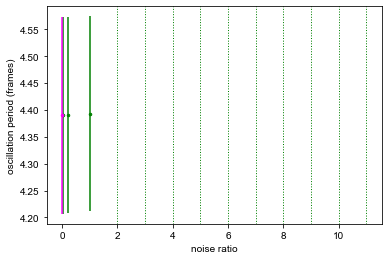

In [15]:
fig, ax = plt.subplots()

ax.set_xlabel("noise ratio")
ax.set_ylabel("oscillation period (frames)")

for n, std in enumerate(gauss_std):
    period = periods_collect[n]
    period_std = periods_std_collect[n]
    if period > 0:
        ax.errorbar(
            std / image_std,
            period,
            yerr=period_std,
            marker=".",
            markersize=5,
            color="green",
        )
    else:
        ax.axvline(x=std / image_std, linestyle="dotted", color="green", linewidth=1)

ax.errorbar(
    0, ref_period, yerr=ref_period_std, marker=".", markersize=5, color="magenta"
)
if save:
    fig.set_size_inches(9 * cm, 5 * cm)
    fig.tight_layout()
    fig.savefig(
        f"save_output/global_temporal_noise_results.png", dpi=save_dpi, transparent=True
    )
plt.show()

## Local velocity analysis

Analysing original image:
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 11.00 pixels/frame
FWHM velocity magnitude: 3.50 pixels/frame
Median velocity magnitude: 12.45 pixels/frame


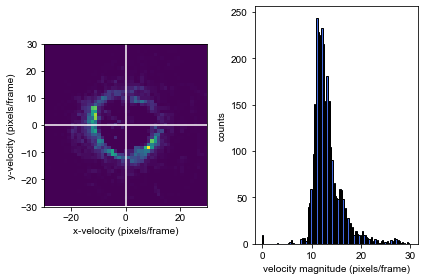

In [16]:
print("Analysing original image:")
halfspan = get_auto_halfspan(Min_st, frames_to_analyse, verbose=False)
(
    velocities,  # velocity magnitude
    forward_wavevector_x,  # unit vector w_x
    forward_wavevector_y,  # unit vector w_y
    all_wheels,  # data generated for velocity wheel (2D histogram)
    crests_x,
    crests_y,
    framenr,
    max_x1,
    max_y1,
    max_x2,
    max_y2,
    fig,
    ax_wheel,
    ax_sum,
) = local_velocity_analysis(
    Min_st,
    4,  # use first ... frames [frames_to_analyse]
    halfspan,
    sampling_width,
    edge,  # width of velocity wheel (2D histogram) and max of magnitude histogram
    bins_wheel,  # number of bins (horizontal/vertical) for velocity wheel (2D histogram)
    binwidth_sum,  # binwidth for velocity mangitude histogram
    kernel_size_general,  # kernel for first smoothing step
    kernel_size_flow,  # kernel for additional smoothing step
    look_ahead=1,  # 1 -> look in propagation direction, -1 -> against it
    demo=True,  # True -> return figure handles
)

bins = np.arange(0, edge + binwidth_sum, binwidth_sum)
(hist_prf, bin_edges) = np.histogram(velocities, bins)
pki = peak_profile.get_maxima(hist_prf, N_max=1)
fwhm_pix = peak_profile.get_FWHM(hist_prf, pki[0])
fwhm_pifr = binwidth_sum * fwhm_pix

ref_median = np.nanmedian(velocities)
ref_peak = bin_edges[pki[0]]
ref_FWHM = fwhm_pifr

if save:
    fig.set_size_inches(9 * cm, 6 * cm)
    fig.tight_layout()
    fig.savefig(
        f"save_output\local_noise_ratio_0_image.png", dpi=save_dpi, transparent=True
    )
plt.show()

Analysing noisy images: noise ratio = 0.02 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 11.00 pixels/frame
FWHM velocity magnitude: 3.50 pixels/frame
Median velocity magnitude: 12.45 pixels/frame


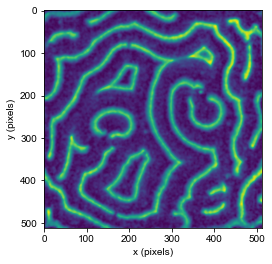

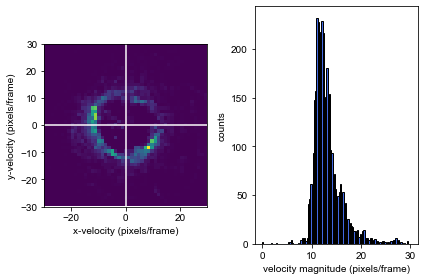

Analysing noisy images: noise ratio = 0.20 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 12.00 pixels/frame
FWHM velocity magnitude: 3.25 pixels/frame
Median velocity magnitude: 12.46 pixels/frame


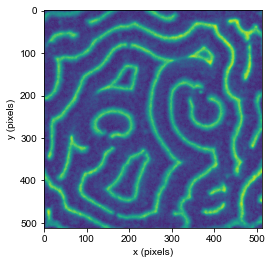

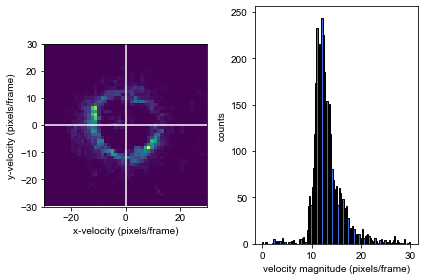

Analysing noisy images: noise ratio = 1.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 12.50 pixels/frame
FWHM velocity magnitude: 4.25 pixels/frame
Median velocity magnitude: 12.46 pixels/frame


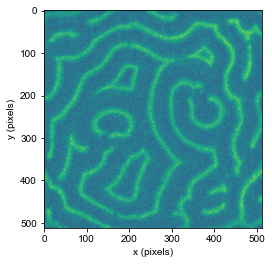

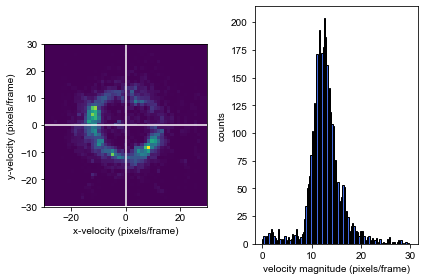

Analysing noisy images: noise ratio = 2.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 11.25 pixels/frame
FWHM velocity magnitude: 5.75 pixels/frame
Median velocity magnitude: 12.04 pixels/frame


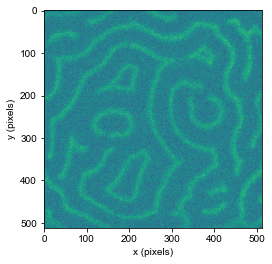

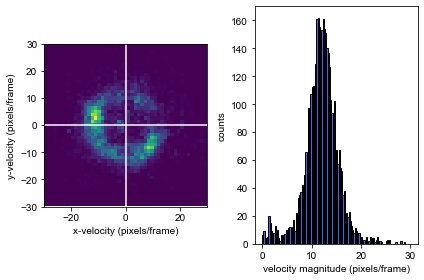

Analysing noisy images: noise ratio = 3.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 11.25 pixels/frame
FWHM velocity magnitude: 5.25 pixels/frame
Median velocity magnitude: 10.82 pixels/frame


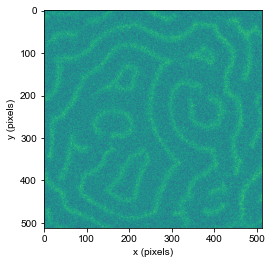

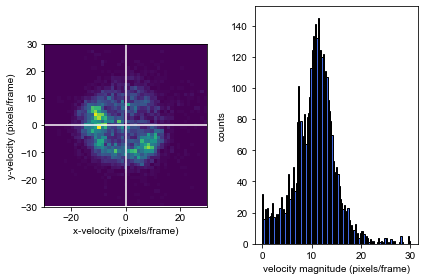

Analysing noisy images: noise ratio = 4.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 10.75 pixels/frame
FWHM velocity magnitude: 6.50 pixels/frame
Median velocity magnitude: 9.55 pixels/frame


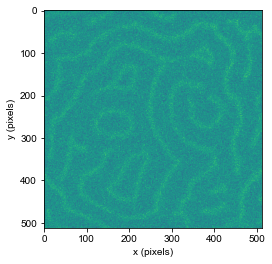

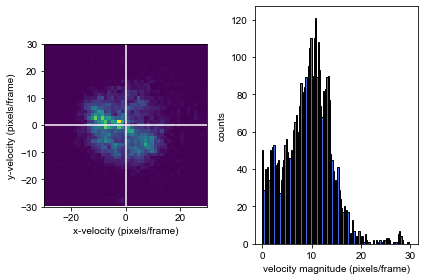

Analysing noisy images: noise ratio = 5.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 8.00 pixels/frame
FWHM velocity magnitude: 8.25 pixels/frame
Median velocity magnitude: 8.02 pixels/frame


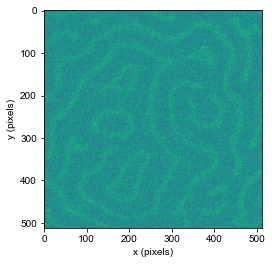

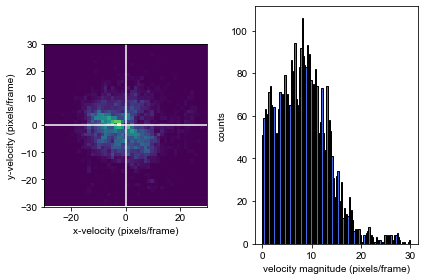

Analysing noisy images: noise ratio = 6.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 6.00 pixels/frame
FWHM velocity magnitude: 5.75 pixels/frame
Median velocity magnitude: 7.48 pixels/frame


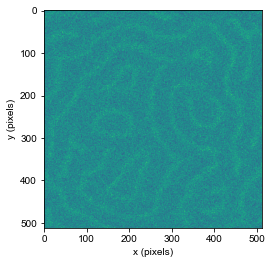

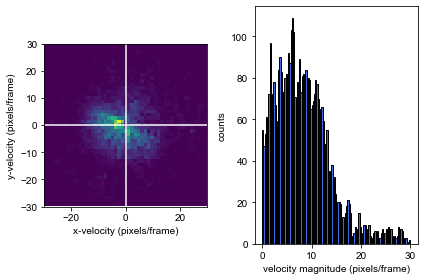

Analysing noisy images: noise ratio = 7.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 2.75 pixels/frame
FWHM velocity magnitude: 15.00 pixels/frame
Median velocity magnitude: 6.32 pixels/frame


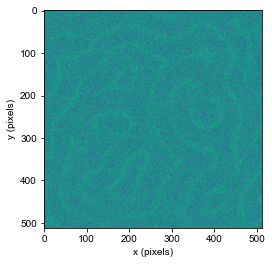

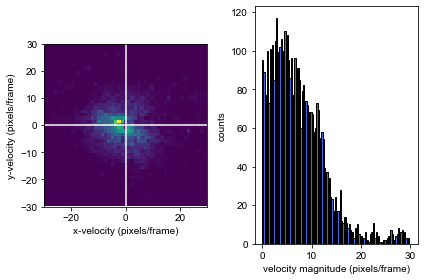

Analysing noisy images: noise ratio = 8.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 7.50 pixels/frame
FWHM velocity magnitude: 7.50 pixels/frame
Median velocity magnitude: 6.87 pixels/frame


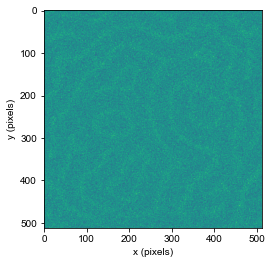

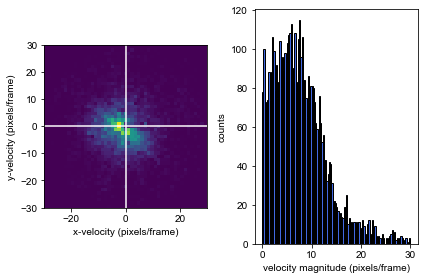

Analysing noisy images: noise ratio = 9.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 4.75 pixels/frame
FWHM velocity magnitude: 6.50 pixels/frame
Median velocity magnitude: 6.36 pixels/frame


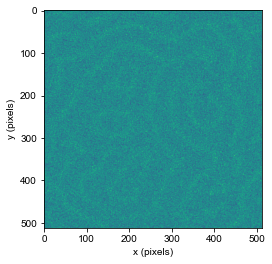

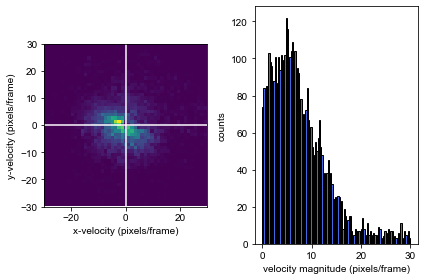

Analysing noisy images: noise ratio = 10.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 1.50 pixels/frame
FWHM velocity magnitude: 18.00 pixels/frame
Median velocity magnitude: 6.85 pixels/frame


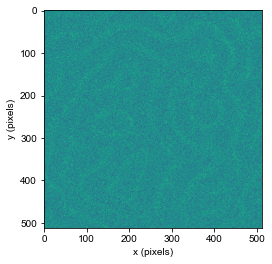

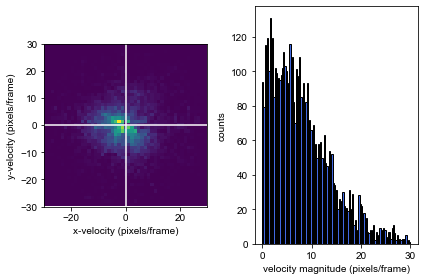

Analysing noisy images: noise ratio = 11.00 a.u.
Analysing 4 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
peak velocity magnitude: 1.50 pixels/frame
FWHM velocity magnitude: 18.00 pixels/frame
Median velocity magnitude: 7.11 pixels/frame


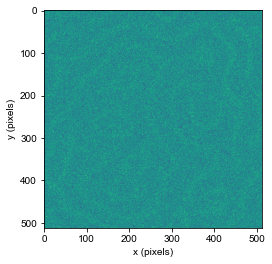

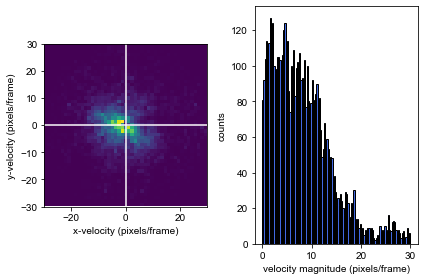

In [17]:
# Next, create noisy images and analyse as well

medianvelocity_collect = []
peakvelocity_collect = []
fwhm_velocity_collect = []

for std in gauss_std:

    ratio = std / image_std
    print(f"Analysing noisy images: noise ratio = {ratio:.02f} a.u.")
    Min_st_noise = np.empty((nt, ny, nx))

    for frame in range(nt):
        img = Min_st[frame, :, :]
        noise_img = add_gaussian_noise(img, mean=0, std=std)
        Min_st_noise[frame, :, :] = noise_img

    fig, ax = plt.subplots()
    ax.imshow(Min_st_noise[0, :, :])
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")

    (
        velocities,  # velocity magnitude
        forward_wavevector_x,  # unit vector w_x
        forward_wavevector_y,  # unit vector w_y
        all_wheels,  # data generated for velocity wheel (2D histogram)
        crests_x,
        crests_y,
        framenr,
        max_x1,
        max_y1,
        max_x2,
        max_y2,
        fig,
        ax_wheel,
        ax_sum,
    ) = local_velocity_analysis(
        Min_st_noise,
        4,  # use first ... frames [frames_to_analyse]
        halfspan,
        sampling_width,
        edge,  # width of velocity wheel (2D histogram) and max of magnitude histogram
        bins_wheel,  # number of bins (horizontal/vertical) for velocity wheel (2D histogram)
        binwidth_sum,  # binwidth for velocity mangitude histogram
        kernel_size_general,  # kernel for first smoothing step
        kernel_size_flow,  # kernel for additional smoothing step
        look_ahead=1,  # 1 -> look in propagation direction, -1 -> against it
        demo=True,  # True -> return figure handles
    )

    # some extra numbers processed from the histogram
    bins = np.arange(0, edge + binwidth_sum, binwidth_sum)
    (hist_prf, bin_edges) = np.histogram(velocities, bins)
    pki = peak_profile.get_maxima(hist_prf, N_max=1)
    fwhm_pix = peak_profile.get_FWHM(hist_prf, pki[0])
    fwhm_pifr = binwidth_sum * fwhm_pix

    medianvelocity_collect.append(np.nanmedian(velocities))
    peakvelocity_collect.append(bin_edges[pki[0]])
    fwhm_velocity_collect.append(fwhm_pifr)

    if save:
        fig.set_size_inches(9 * cm, 6 * cm)
        fig.tight_layout()
        fig.savefig(
            f"save_output\local_noise_ratio_{std/image_std:.02f}_results.png",
            dpi=save_dpi,
            transparent=True,
        )
    plt.show()
plt.close("all")

### Results:
In the following, we consider the peak velocity obtained for the peak velocity as reference and compare the results obtained for different image sizes.<br>
blue: median magnitude, green: peak magnitude (from histogram), magenta: peak magnitude for original image

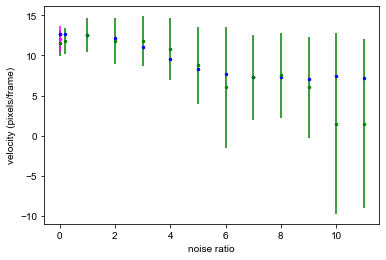

medianvelocity_collect=[12.63829380330684, 12.652316259270485, 12.562606960925512, 12.14929565405999, 11.064500186165024, 9.543139816968877, 8.355906790648932, 7.7366074828295694, 7.342582427215849, 7.348169830307873, 7.11249230443781, 7.424781363218793, 7.219250827677879]
peakvelocity_collect=[11.5, 11.75, 12.5, 11.75, 11.75, 10.75, 8.75, 6.0, 7.25, 7.5, 6.0, 1.5, 1.5]
fwhm_velocity_collect=[3.25, 3.25, 4.25, 5.75, 6.25, 7.75, 9.5, 15.0, 10.5, 10.5, 12.5, 22.5, 21.0]


In [18]:
fig, ax = plt.subplots()

ax.set_xlabel("noise ratio")
ax.set_ylabel("velocity (pixels/frame)")

for n, std in enumerate(gauss_std):
    wavelength_median = medianvelocity_collect[n]
    wavelength_peak = peakvelocity_collect[n]
    wavelength_std = fwhm_velocity_collect[n] / 2
    ax.errorbar(
        std / image_std,
        wavelength_peak,
        yerr=wavelength_std,
        marker=".",
        markersize=5,
        color="green",
    )
    ax.plot(std / image_std, wavelength_median, marker=".", markersize=5, color="blue")

nt, ny, nx = np.shape(Min_st)
ax.errorbar(0, ref_peak, yerr=ref_FWHM / 2, marker=".", markersize=5, color="magenta")
ax.plot(0, ref_median, marker=".", markersize=5, color="blue")

if save:
    fig.set_size_inches(9 * cm, 5 * cm)
    fig.tight_layout()
    fig.savefig(f"save_output\local_noise_results.png", dpi=save_dpi, transparent=True)
plt.show()

print(f"{medianvelocity_collect=}")
print(f"{peakvelocity_collect=}")
print(f"{fwhm_velocity_collect=}")